In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import os
os.chdir('Data')

In [2]:
# read in all the files
df_list = []
for game in (['reg','post']):
    for year in range(2009,2020):
        df_loop =dd.read_csv('{}_pbp_{}.csv'.format(game,year),
                             usecols=['play_id','game_id','home_team','away_team','posteam','posteam_type','defteam',
                                      'side_of_field','game_date','quarter_seconds_remaining','game_seconds_remaining',
                                      'game_half','qtr','down','sp','time','yrdln','ydstogo','desc','play_type',
                                      'kick_distance','home_timeouts_remaining','away_timeouts_remaining','timeout',
                                      'timeout_team','posteam_timeouts_remaining','defteam_timeouts_remaining',
                                      'posteam_score','defteam_score','score_differential','opp_fg_prob',
                                      'field_goal_attempt','kicker_player_name','kicker_player_id','field_goal_result'],
                             dtype={'game_seconds_remaining': 'float64','quarter_seconds_remaining': 'float64',
                                    'defteam_timeouts_remaining': 'float64','field_goal_attempt': 'float64',
                                    'posteam_timeouts_remaining': 'float64','timeout': 'float64',
                                    'field_goal_result': 'object'})
        
        # adding the type of game
        df_loop = df_loop.assign(playoff=game)[['playoff'] + df_loop.columns.tolist()]
        
        # adding the year
        df_loop = df_loop.assign(season=year)[['season'] + df_loop.columns.tolist()]
        df_list.append(df_loop)

# concatenate all the files
df = dd.concat(df_list,axis=0,interleave_partitions=True)

In [3]:
### create column with type of FG: iced, no-timeout or timeout called by the offense

df['type'] = 0

# iced
df['type'] = df['type'].mask((df['play_type']=='field_goal') & (df['score_differential'].shift(1) <= 0) 
                             & (df['score_differential'].shift(1) >= -3) & (df['qtr']==4) 
                             & (df['quarter_seconds_remaining'] <= 60) & (df['timeout'].shift(1) == 1)
                             & (df['timeout_team'].shift(1)==df['defteam'].shift(1)), 'iced')

df['type'] = df['type'].mask((df['play_type']=='field_goal') & (df['score_differential'].shift(1) <= 0) 
                             & (df['score_differential'].shift(1) >= -3) & (df['qtr']==5)
                             & (df['timeout'].shift(1) == 1) 
                             & (df['timeout_team'].shift(1)==df['defteam'].shift(1)), 'iced')

# no timeout
df['type'] = df['type'].mask((df['play_type']=='field_goal') & (df['score_differential'].shift(1) <= 0) 
                             & (df['score_differential'].shift(1) >= -3) & (df['qtr']==4) 
                             & (df['quarter_seconds_remaining'] <= 60) & (df['timeout'].shift(1) == 0), 'no_timeout')

df['type'] = df['type'].mask((df['play_type']=='field_goal') & (df['score_differential'].shift(1) <= 0) 
                             & (df['score_differential'].shift(1) >= -3) & (df['qtr']==5) 
                             & (df['timeout'].shift(1) == 0), 'no_timeout')

# TO called by the offense
df['type'] = df['type'].mask((df['play_type']=='field_goal') & (df['score_differential'].shift(1) <= 0) 
                             & (df['score_differential'].shift(1) >= -3) & (df['qtr']==4) 
                             & (df['quarter_seconds_remaining'] <= 60) & (df['timeout'].shift(1) == 1)
                             & (df['timeout_team'].shift(1)==df['posteam'].shift(1)), 'off_timeout')

df['type'] = df['type'].mask((df['play_type']=='field_goal') & (df['score_differential'].shift(1) <= 0) 
                             & (df['score_differential'].shift(1) >= -3) & (df['qtr']==5) 
                             & (df['timeout'].shift(1) == 1)
                             & (df['timeout_team'].shift(1)==df['posteam'].shift(1)), 'off_timeout')

# create iced vs non-iced column
df['iced'] = 'non_iced'
df['iced'] = df['iced'].mask((df['type']=='iced'), 'iced')

# create overtime column
df['overtime'] = 0
df['overtime'] = df['overtime'].mask((df['qtr']==5), 1)


# select only game deciding FGs
fg = df.loc[df['type']!=0].compute()

# replace 
fg['field_goal_result'] = fg['field_goal_result'].replace({'blocked':'missed'})

/opt/anaconda3/lib/python3.8/site-packages/dask/core.py:121: DtypeWarning: Columns (46) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*(_execute_task(a, cache) for a in args))
/opt/anaconda3/lib/python3.8/site-packages/dask/core.py:121: DtypeWarning: Columns (46) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*(_execute_task(a, cache) for a in args))


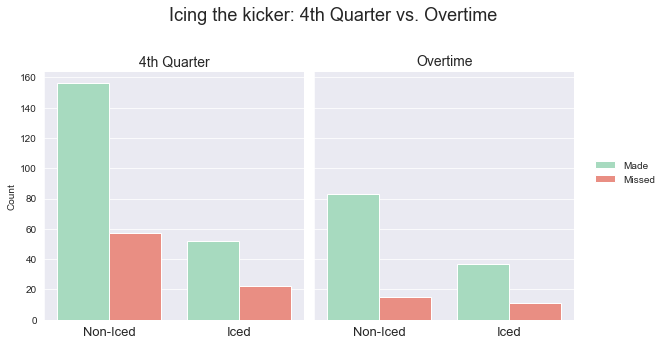

In [4]:
# visualize frequencies

sns.set_style('darkgrid')

g = sns.catplot(data=fg, kind='count',x='iced',hue='field_goal_result',col='overtime',
            palette=['#9FE2BF','salmon'],height=5, aspect=.8,legend_out = True)

g.set_axis_labels('', 'Count') # change outer labels
g.set_xticklabels(['Non-Iced', 'Iced'],fontsize=13) # change inner x labels
g._legend.set_title('') # change legend title
for t, l in zip(g._legend.texts, ['Made','Missed']): # change legend labels
    t.set_text(l)
axes = g.axes.flatten() 
axes[0].set_title('4th Quarter',fontsize=14) # change subplots titles
axes[1].set_title('Overtime',fontsize=14)

plt.subplots_adjust(top=0.8) # adjust axes to add superior title
g.fig.suptitle('Icing the kicker: 4th Quarter vs. Overtime',fontsize=18) # add superior title

plt.show()

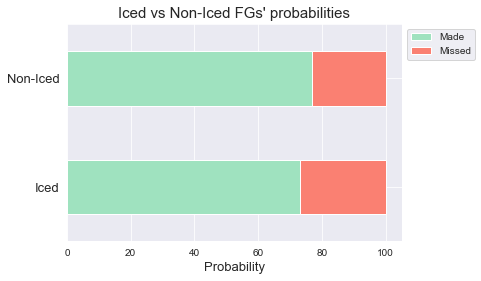

In [5]:
# calculate frequencies 
aggre = fg.groupby(['iced','field_goal_result'])[['season']].count().rename({'season':'frequencies'},axis=1)
final = aggre.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

# stacked bar chart
a = final['frequencies'].unstack()

a.plot.barh(stacked=True,color=['#9FE2BF','salmon'])
plt.xlabel('Probability',fontsize=13)
plt.ylabel('')
plt.title("Iced vs Non-Iced FGs' probabilities",fontsize=15)
plt.yticks(np.arange(2),('Iced','Non-Iced'),rotation=0,fontsize=13)
plt.legend(['Made','Missed'], bbox_to_anchor=(1,1))

plt.show()

In [6]:
# chi square test

iced_made = len(fg.loc[(fg['iced']=='iced')&(fg['field_goal_result']=='made')])
iced_missed = len(fg.loc[(fg['iced']=='iced')&(fg['field_goal_result']=='missed')])
non_iced_made = len(fg.loc[(fg['iced']=='non_iced')&(fg['field_goal_result']=='made')])
non_iced_missed = len(fg.loc[(fg['iced']=='non_iced')&(fg['field_goal_result']=='missed')])

# creating the contingency table

cont_table = pd.DataFrame(
    [
        [iced_made,iced_missed],
        [non_iced_made,non_iced_missed]
    ],
    index=["iced","non_iced"],
    columns=["made","missed"])

chi_value = chi2_contingency(cont_table)[0]
p_value = chi2_contingency(cont_table)[1]
degree_of_freedom = chi2_contingency(cont_table)[2]

print("Chi value is " + str(chi_value),"P-Value is " + str(p_value), sep='\n')

Chi value is 0.528162189610451
P-Value is 0.4673805395066779


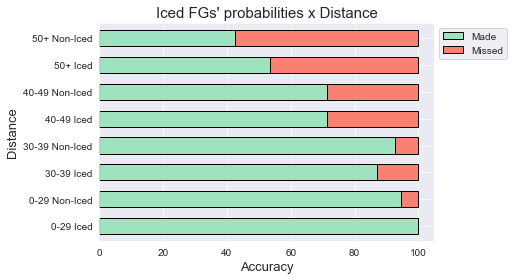

In [7]:
fg.loc[fg['kick_distance']< 30,'distance'] = '0-29'
fg.loc[(fg['kick_distance']>=30) & (fg['kick_distance']< 40),'distance'] = '30-39'
fg.loc[(fg['kick_distance']>=40) & (fg['kick_distance']< 50),'distance'] = '40-49'
fg.loc[fg['kick_distance']>50,'distance'] = '50+'

aggre = fg.groupby(['distance','iced','field_goal_result'])[['season']].count().rename({'season':'frequencies'},axis=1)

aggre = aggre.groupby(level=[0,1]).apply(lambda x:100 * x / float(x.sum())).unstack()


ax = aggre.plot.barh(stacked=True,color=['#9FE2BF','salmon'],width = 0.60, edgecolor='black')

plt.ylabel('Distance',fontsize=13)
plt.xlabel('Accuracy',fontsize=13)
plt.title("Iced FGs' probabilities x Distance",fontsize=15)
plt.legend(['Made','Missed'], bbox_to_anchor=(1,1))

labels = ['0-29 Iced','0-29 Non-Iced',
          '30-39 Iced','30-39 Non-Iced',
          '40-49 Iced','40-49 Non-Iced',
          '50+ Iced','50+ Non-Iced']

ax.set_yticklabels(labels)


plt.show()